In [2]:
import math
import numpy as np
import tensorflow as tf
from tensorflow import keras
import tensorflow_addons as tfa
import matplotlib.pyplot as plt
from tensorflow.keras import layers
from preprocessing import get_datasets
from model_helper import *

In [14]:
train_dataset, validation_dataset, test_dataset = get_datasets(256)

In [5]:
NUM_CLASSES = 37
INPUT_SHAPE = (69, 69, 3)

In [6]:
# AUGMENTATION
IMAGE_SIZE = 72
PATCH_SIZE = 6
NUM_PATCHES = (IMAGE_SIZE // PATCH_SIZE) ** 2

# ARCHITECTURE
LAYER_NORM_EPS = 1e-6
TRANSFORMER_LAYERS = 8
PROJECTION_DIM = 64
NUM_HEADS = 4
TRANSFORMER_UNITS = [
    PROJECTION_DIM * 2,
    PROJECTION_DIM,
]
MLP_HEAD_UNITS = [2048, 1024]

In [7]:
class ShiftedPatchTokenization(layers.Layer):
    def __init__(
        self,
        image_size=IMAGE_SIZE,
        patch_size=PATCH_SIZE,
        num_patches=NUM_PATCHES,
        projection_dim=PROJECTION_DIM,
        vanilla=False,
        **kwargs,
    ):
        super().__init__(**kwargs)
        self.vanilla = vanilla  # Flag to swtich to vanilla patch extractor
        self.image_size = image_size
        self.patch_size = patch_size
        self.half_patch = patch_size // 2
        self.flatten_patches = layers.Reshape((num_patches, -1))
        self.projection = layers.Dense(units=projection_dim)
        self.layer_norm = layers.LayerNormalization(epsilon=LAYER_NORM_EPS)

    def crop_shift_pad(self, images, mode):
        # Build the diagonally shifted images
        if mode == "left-up":
            crop_height = self.half_patch
            crop_width = self.half_patch
            shift_height = 0
            shift_width = 0
        elif mode == "left-down":
            crop_height = 0
            crop_width = self.half_patch
            shift_height = self.half_patch
            shift_width = 0
        elif mode == "right-up":
            crop_height = self.half_patch
            crop_width = 0
            shift_height = 0
            shift_width = self.half_patch
        else:
            crop_height = 0
            crop_width = 0
            shift_height = self.half_patch
            shift_width = self.half_patch

        # Crop the shifted images and pad them
        crop = tf.image.crop_to_bounding_box(
            images,
            offset_height=crop_height,
            offset_width=crop_width,
            target_height=self.image_size - self.half_patch,
            target_width=self.image_size - self.half_patch,
        )
        shift_pad = tf.image.pad_to_bounding_box(
            crop,
            offset_height=shift_height,
            offset_width=shift_width,
            target_height=self.image_size,
            target_width=self.image_size,
        )
        return shift_pad

    def call(self, images):
        if not self.vanilla:
            # Concat the shifted images with the original image
            images = tf.concat(
                [
                    images,
                    self.crop_shift_pad(images, mode="left-up"),
                    self.crop_shift_pad(images, mode="left-down"),
                    self.crop_shift_pad(images, mode="right-up"),
                    self.crop_shift_pad(images, mode="right-down"),
                ],
                axis=-1,
            )
        # Patchify the images and flatten it
        patches = tf.image.extract_patches(
            images=images,
            sizes=[1, self.patch_size, self.patch_size, 1],
            strides=[1, self.patch_size, self.patch_size, 1],
            rates=[1, 1, 1, 1],
            padding="VALID",
        )
        flat_patches = self.flatten_patches(patches)
        if not self.vanilla:
            # Layer normalize the flat patches and linearly project it
            tokens = self.layer_norm(flat_patches)
            tokens = self.projection(tokens)
        else:
            # Linearly project the flat patches
            tokens = self.projection(flat_patches)
        return (tokens, patches)

In [8]:
for images, _ in train_dataset.take(1):
    image = images[0]
    print(image.shape)
    resized_image = tf.image.resize(
        tf.convert_to_tensor([image]), size=(IMAGE_SIZE, IMAGE_SIZE)
    )
    print(resized_image.shape)
    token, patch = ShiftedPatchTokenization(vanilla=True)(resized_image)
    print(token.shape, patch.shape)

(69, 69, 3)
(1, 72, 72, 3)
(1, 144, 64) (1, 12, 12, 108)


2023-12-03 23:27:16.508474: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:606] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


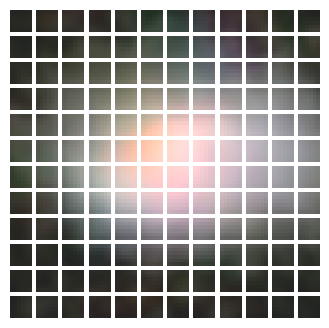

In [9]:
for images, _ in train_dataset.take(1):
    image = images[0]
    resized_image = tf.image.resize(
        tf.convert_to_tensor([image]), size=(IMAGE_SIZE, IMAGE_SIZE)
    )
    # Vanilla patch maker: This takes an image and divides into
    # patches as in the original ViT paper
    (token, patch) = ShiftedPatchTokenization(vanilla=True)(resized_image / 255)
    (token, patch) = (token[0], patch[0])
    n = patch.shape[0]
    count = 1
    plt.figure(figsize=(4, 4))
    for row in range(n):
        for col in range(n):
            plt.subplot(n, n, count)
            count = count + 1
            image = tf.reshape(patch[row][col], (PATCH_SIZE, PATCH_SIZE, 3))
            plt.imshow(image)
            plt.axis("off")
    plt.show()

In [10]:
class PatchEncoder(layers.Layer):
    def __init__(
        self, num_patches=NUM_PATCHES, projection_dim=PROJECTION_DIM, **kwargs
    ):
        super().__init__(**kwargs)
        self.num_patches = num_patches
        self.position_embedding = layers.Embedding(
            input_dim=num_patches, output_dim=projection_dim
        )
        self.positions = tf.range(start=0, limit=self.num_patches, delta=1)

    def call(self, encoded_patches):
        encoded_positions = self.position_embedding(self.positions)
        encoded_patches = encoded_patches + encoded_positions
        return encoded_patches

In [11]:
class MultiHeadAttentionLSA(tf.keras.layers.MultiHeadAttention):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)
        # The trainable temperature term. The initial value is
        # the square root of the key dimension.
        self.tau = tf.Variable(math.sqrt(float(self._key_dim)), trainable=True)

    def _compute_attention(self, query, key, value, attention_mask=None, training=None):
        query = tf.multiply(query, 1.0 / self.tau)
        attention_scores = tf.einsum(self._dot_product_equation, key, query)
        attention_scores = self._masked_softmax(attention_scores, attention_mask)
        attention_scores_dropout = self._dropout_layer(
            attention_scores, training=training
        )
        attention_output = tf.einsum(
            self._combine_equation, attention_scores_dropout, value
        )
        return attention_output, attention_scores

In [12]:
def mlp(x, hidden_units, dropout_rate):
    for units in hidden_units:
        x = layers.Dense(units, activation=tf.nn.gelu)(x)
        x = layers.Dropout(dropout_rate)(x)
    return x


# Build the diagonal attention mask
diag_attn_mask = 1 - tf.eye(NUM_PATCHES)
diag_attn_mask = tf.cast([diag_attn_mask], dtype=tf.int8)

In [13]:
def create_vit_classifier(vanilla=False):
    inputs = layers.Input(shape=INPUT_SHAPE)
    # Resize data
    resized = layers.Resizing(IMAGE_SIZE, IMAGE_SIZE)(inputs)
    # Create patches.
    (tokens, _) = ShiftedPatchTokenization(vanilla=vanilla)(resized)
    # Encode patches.
    encoded_patches = PatchEncoder()(tokens)

    # Create multiple layers of the Transformer block.
    for _ in range(TRANSFORMER_LAYERS):
        # Layer normalization 1.
        x1 = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
        # Create a multi-head attention layer.
        if not vanilla:
            attention_output = MultiHeadAttentionLSA(
                num_heads=NUM_HEADS, key_dim=PROJECTION_DIM, dropout=0.1
            )(x1, x1, attention_mask=diag_attn_mask)
        else:
            attention_output = layers.MultiHeadAttention(
                num_heads=NUM_HEADS, key_dim=PROJECTION_DIM, dropout=0.1
            )(x1, x1)
        # Skip connection 1.
        x2 = layers.Add()([attention_output, encoded_patches])
        # Layer normalization 2.
        x3 = layers.LayerNormalization(epsilon=1e-6)(x2)
        # MLP.
        x3 = mlp(x3, hidden_units=TRANSFORMER_UNITS, dropout_rate=0.1)
        # Skip connection 2.
        encoded_patches = layers.Add()([x3, x2])

    # Create a [batch_size, projection_dim] tensor.
    representation = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
    representation = layers.Flatten()(representation)
    representation = layers.Dropout(0.5)(representation)
    # Add MLP.
    features = mlp(representation, hidden_units=MLP_HEAD_UNITS, dropout_rate=0.5)
    # Classify outputs.
    predictions = layers.Dense(NUM_CLASSES, activation='sigmoid')(features)
    # Create the Keras model.
    model = keras.Model(inputs=inputs, outputs=predictions)
    return model

Epoch 1/50
193/193 [==============================] - 46s 160ms/step - loss: 0.3327 - accuracy: 0.4943 - root_mean_squared_error: 0.1842 - val_loss: 0.2852 - val_accuracy: 0.5965 - val_root_mean_squared_error: 0.1488
Epoch 2/50
193/193 [==============================] - 30s 156ms/step - loss: 0.2966 - accuracy: 0.5404 - root_mean_squared_error: 0.1596 - val_loss: 0.2821 - val_accuracy: 0.5545 - val_root_mean_squared_error: 0.1447
Epoch 3/50
193/193 [==============================] - 30s 156ms/step - loss: 0.2886 - accuracy: 0.5535 - root_mean_squared_error: 0.1527 - val_loss: 0.2745 - val_accuracy: 0.6116 - val_root_mean_squared_error: 0.1382
Epoch 4/50
193/193 [==============================] - 30s 156ms/step - loss: 0.2835 - accuracy: 0.5663 - root_mean_squared_error: 0.1481 - val_loss: 0.2708 - val_accuracy: 0.6446 - val_root_mean_squared_error: 0.1348
Epoch 5/50
193/193 [==============================] - 30s 156ms/step - loss: 0.2794 - accuracy: 0.5774 - root_mean_squared_error: 0.

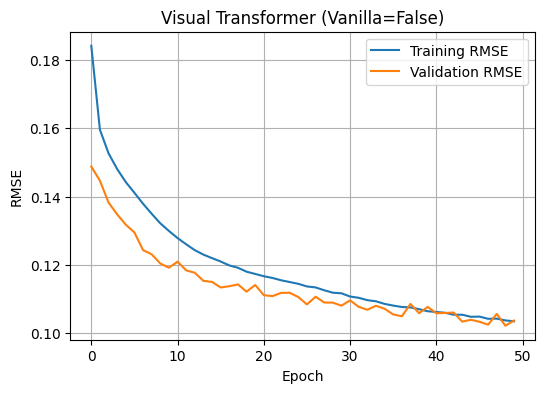

INFO:tensorflow:Assets written to: ./models/visual_transformer_(vanilla=false)/assets


INFO:tensorflow:Assets written to: ./models/visual_transformer_(vanilla=false)/assets


313/313 [==============================] - 18s 55ms/step


In [28]:
name = 'Visual Transformer (Vanilla=False)'
model = create_vit_classifier(vanilla=False)
history = compile_and_fit(model, train_dataset, validation_dataset, epochs=50)
plot_history(history, name)
save(model, test_dataset, name)

In [16]:
# batch size 256
LEARNING_RATE = 0.001
WEIGHT_DECAY = 0.0001
optimizer = keras.optimizers.AdamW(
        learning_rate=LEARNING_RATE, weight_decay=WEIGHT_DECAY
    )

name = 'Visual Transformer AdamW'
model = create_vit_classifier(vanilla=False)
history = compile_and_fit(model, train_dataset, validation_dataset, epochs=500, optimizer=optimizer)
plot_history(history, name)
save(model, test_dataset, name)

Epoch 1/500
193/193 [==============================] - 49s 165ms/step - loss: 0.3228 - accuracy: 0.5258 - root_mean_squared_error: 0.1757 - val_loss: 0.2808 - val_accuracy: 0.5926 - val_root_mean_squared_error: 0.1441
Epoch 2/500
193/193 [==============================] - 31s 162ms/step - loss: 0.2829 - accuracy: 0.5741 - root_mean_squared_error: 0.1482 - val_loss: 0.2702 - val_accuracy: 0.5890 - val_root_mean_squared_error: 0.1367
Epoch 3/500
193/193 [==============================] - 32s 163ms/step - loss: 0.2758 - accuracy: 0.5949 - root_mean_squared_error: 0.1415 - val_loss: 0.2653 - val_accuracy: 0.6426 - val_root_mean_squared_error: 0.1311
Epoch 4/500
193/193 [==============================] - 32s 165ms/step - loss: 0.2714 - accuracy: 0.6150 - root_mean_squared_error: 0.1370 - val_loss: 0.2616 - val_accuracy: 0.6536 - val_root_mean_squared_error: 0.1272
Epoch 5/500
193/193 [==============================] - 33s 170ms/step - loss: 0.2671 - accuracy: 0.6456 - root_mean_squared_erro

Epoch 1/50
1540/1540 [==============================] - 110s 60ms/step - loss: 0.2926 - accuracy: 0.5658 - root_mean_squared_error: 0.1563 - val_loss: 0.2690 - val_accuracy: 0.6380 - val_root_mean_squared_error: 0.1360
Epoch 2/50
1540/1540 [==============================] - 92s 60ms/step - loss: 0.2759 - accuracy: 0.6046 - root_mean_squared_error: 0.1421 - val_loss: 0.2683 - val_accuracy: 0.6549 - val_root_mean_squared_error: 0.1353
Epoch 3/50
1540/1540 [==============================] - 92s 60ms/step - loss: 0.2715 - accuracy: 0.6213 - root_mean_squared_error: 0.1377 - val_loss: 0.2641 - val_accuracy: 0.6731 - val_root_mean_squared_error: 0.1307
Epoch 4/50
1540/1540 [==============================] - 91s 59ms/step - loss: 0.2694 - accuracy: 0.6324 - root_mean_squared_error: 0.1356 - val_loss: 0.2581 - val_accuracy: 0.6913 - val_root_mean_squared_error: 0.1232
Epoch 5/50
1540/1540 [==============================] - 91s 59ms/step - loss: 0.2664 - accuracy: 0.6486 - root_mean_squared_err

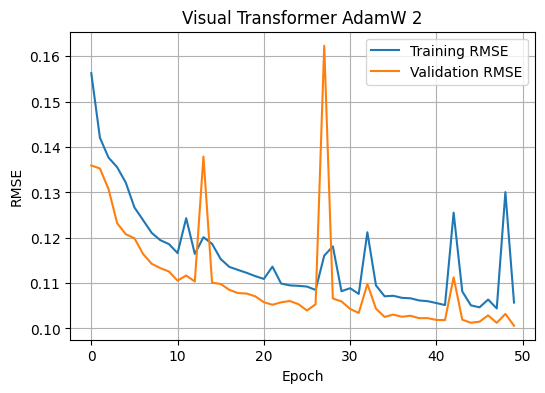

INFO:tensorflow:Assets written to: ./models/visual_transformer_adamw_2/assets


INFO:tensorflow:Assets written to: ./models/visual_transformer_adamw_2/assets


2500/2500 [==============================] - 55s 21ms/step


: 

In [32]:
# batch size 32
LEARNING_RATE = 0.001
WEIGHT_DECAY = 0.0001
optimizer = keras.optimizers.AdamW(
        learning_rate=LEARNING_RATE, weight_decay=WEIGHT_DECAY
    )

name = 'Visual Transformer AdamW 2'
model = create_vit_classifier(vanilla=False)
history = compile_and_fit(model, train_dataset, validation_dataset, epochs=50, optimizer=optimizer)
plot_history(history, name)
save(model, test_dataset, name)